In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import os

import mlflow
import segmentation_models_pytorch as smp
from torchvision.transforms import ToPILImage

from cosas.tracking import get_experiment
from cosas.paths import DATA_DIR
from cosas.data_model import COSASData, Scanncers
from cosas.datasets import Patchdataset
from cosas.misc import set_seed, train_val_split

In [33]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

DEVICE = "cuda"
# experiment = get_experiment()
set_seed(42)  # TODO

cosas_data = COSASData(os.path.join(DATA_DIR, "task2"))
cosas_data.load()

(train_images, train_masks), (val_images, val_masks), (test_images, test_masks) = (
    train_val_split(cosas_data, train_val_test=(0.6, 0.2, 0.2))
)

model = smp.FPN(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    classes=1,
    activation=None,
).to(DEVICE)


#### cosas.datasets

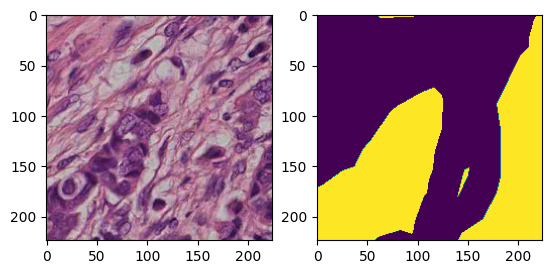

In [62]:
from cosas.datasets import Patchdataset
from matplotlib import pyplot as plt
patchdataset = Patchdataset(train_images, train_masks)
x, y = patchdataset[10]

fig, axes = plt.subplots(1, 2)
axes[0].imshow(x)
axes[1].imshow(y)

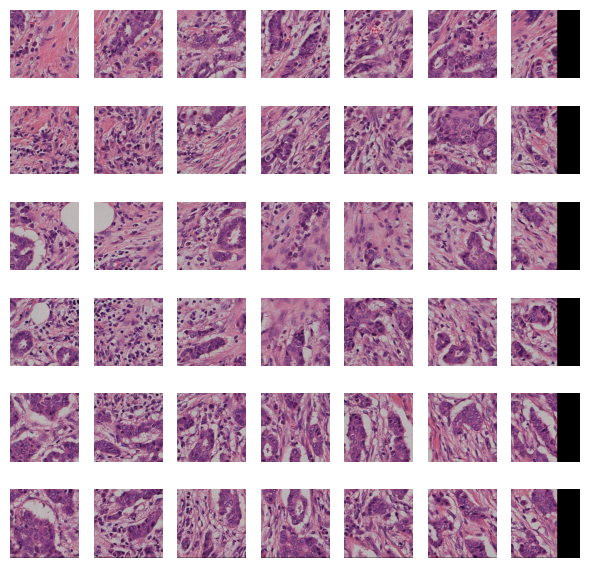

In [63]:
import albumentations as A

from matplotlib import pyplot as plt
from cosas.datasets import WholeSizeDataset
test_transform = A.Compose(
    [
        ToTensorV2(),
    ]
)
wholesize_ds = WholeSizeDataset(train_images, train_masks, test_transform)
raw_xs, raw_ys = wholesize_ds[0]

fig, ax = plt.subplots(figsize=(6, 6), nrows=6, ncols=7)
for n, i in enumerate(raw_xs):
    ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")

plt.tight_layout()
plt.show()

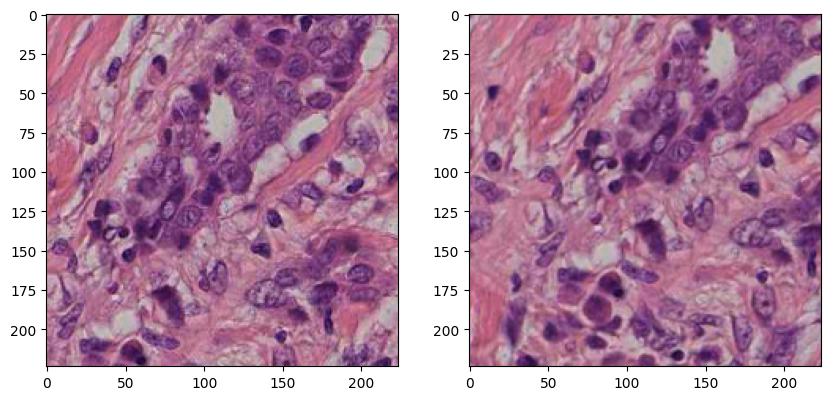

In [64]:
test_transform = A.Compose(
    [
        A.ElasticTransform(p=1),
        ToTensorV2(),
    ]
)
wholesize_ds = WholeSizeDataset(train_images, train_masks, test_transform)
elastic_xs, elastic_ys = wholesize_ds[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(ToPILImage()(raw_xs[1]))
axes[1].imshow(ToPILImage()(elastic_xs[1]))

#### casas.trainer

In [66]:
import torch
from torch.utils.data import DataLoader
from cosas.metrics import calculate_metrics, Metrics, AverageMeter
from cosas.trainer import BinaryClassifierTrainer
from cosas.tracking import TRACKING_URI, get_experiment

train_transform = A.Compose(
        [
            A.RandomCrop(height=224, width=224, p=1),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            # TODO: RandomRotation90 추가
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]
    )

train_dataset = Patchdataset(train_images, train_masks, train_transform)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
)

test_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = WholeSizeDataset(val_images, val_masks, test_transform)
num_epochs = 2
n_steps = len(train_dataloader)
trainer = BinaryClassifierTrainer(
    model, 
    torch.nn.functional.binary_cross_entropy_with_logits, 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
)

mlflow.set_tracking_uri(TRACKING_URI)
experiment = get_experiment("cosas")

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="ipynb") as run:
    trainer.train(
        train_dataloader,
        val_dataset,
        epochs=1,
        n_patience=7,
    )
    mlflow.pytorch.log_model(trainer.model, "model")
    

    test_loss, test_metrics = trainer.test(
        WholeSizeDataset(test_images, test_masks, test_transform), 
        phase="test",
        epoch=0,
        threshold=0.5,
        save_plot=True
    )
    mlflow.log_metric("test_loss", test_loss.avg)
    mlflow.log_metrics(test_metrics.to_dict(prefix="test_"))    

 |                                | train | EPOCH 0: [9/824] | eta:307 | total_loss: 0.6966 | f1: 0.6539|acc: 0.7733|sen: 0.6403|spec: 0.8696|auroc: 0.8740|prauc: 0.8037|iou: 0.4960|dice: 0.6539

Test

In [ ]:
import mlflow
from cosas.tracking import TRACKING_URI
from cosas.datasets import WholeSizeDataset
mlflow.set_tracking_uri(TRACKING_URI)

model = mlflow.pytorch.load_model(
    "file:///vast/AI_team/mlflow_artifact/13/a08551e4a9c2453e9cd29a18c2b015dd/artifacts/model"
).eval()

transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
with torch.no_grad():
    test_dataset = WholeSizeDataset(test_images, test_masks, transform)
    xs, ys = test_dataset[1]
    logits = model(xs)
    confidences = torch.sigmoid(logits)

#### cosas.transforms

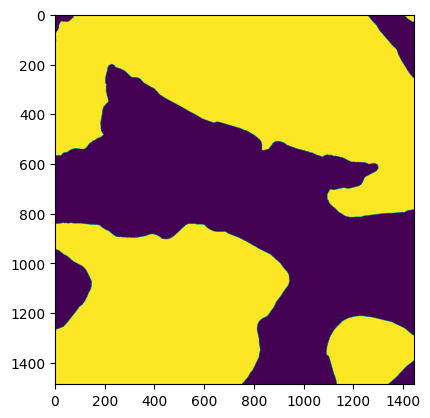

In [ ]:
from cosas.transforms import reverse_tesellation, remove_pad

original_size = test_masks[1].shape
test_mask = reverse_tesellation(ys, original_size)
res = remove_pad(test_mask, original_size)

plt.imshow(ToPILImage()(res))

### cosas.misc

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

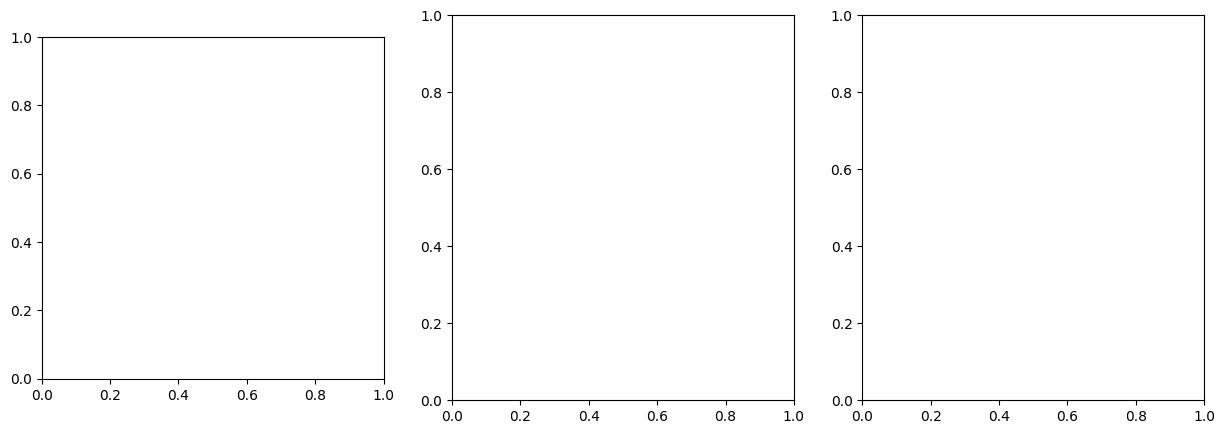

In [ ]:
from cosas.misc import plot_xypred

plot_xypred(xs, ys, confidences)